# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [8]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN
4,5,pilot,0,NaN
5,6,pilot,0,NaN
6,7,pilot,0,NaN
7,8,pilot,0,NaN


## Read in data files

In [14]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False

test_types = ['day2_noarrows_round2', 'day3_test1', 'day3_test2']
test_trials = ['training']#, 'test1', 'test2']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for env in proj['envs']:
            for test_type, test_trial in zip(test_types, test_trials):
    #             print env
                # add test file
                test_file = glob.glob(op.join(dirs['datadir'], 'nav', test_type, env, 
                                    subid,'session_*', 'log.txt'))[0]
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)
                d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d2['subid'] = subid
                d2['env'] = env
                d2['test_trial'] = test_trial

                # force time to be integer, diff from end to beginning
                d2.time = d2.time.astype(int)
                d2.time = d2.time - d2.time.min()

                df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)


1
2
3
4
5
6
7
8


## Look at data

In [16]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,env,test_trial
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,env1,training
1,140,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,env1,training
2,140,0,VR_INIT,,,None,None,None,None,1,env1,training
3,140,0,VR_CREATED,,,None,None,None,None,1,env1,training
4,1946,0,CONF_LOAD,./config.py,None,,,None,None,1,env1,training


### Look at 2D position in space

In [17]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,terrain,"LPoint3f(0, 0, 0)",1,env1,training
1,6656,1,zebra,"LPoint3f(4, 34, 0.5)",1,env1,training
2,6656,1,lettuce,"LPoint3f(26, 52, 0.5)",1,env1,training
3,6656,1,George_Clooney,"LPoint3f(20, 22, 0.5)",1,env1,training
4,6656,1,zzz,"LPoint3f(12, 52, 0.2)",1,env1,training


In [18]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,env,test_trial,x,y,z
0,6656,terrain,1,env1,training,0,0,0.0
1,6656,zebra,1,env1,training,4,34,0.5
2,6656,lettuce,1,env1,training,26,52,0.5
3,6656,George_Clooney,1,env1,training,20,22,0.5
4,6656,zzz,1,env1,training,12,52,0.2


(<matplotlib.figure.Figure at 0x11b3de650>,
 <matplotlib.axes.AxesSubplot at 0x119946990>)

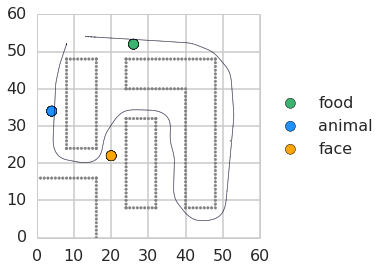

In [19]:
plot_paths(env='env1', subj='1', 
           dp=dp[dp.test_trial == 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x12c3c62d0>,
 <matplotlib.axes.AxesSubplot at 0x12c3dd390>)

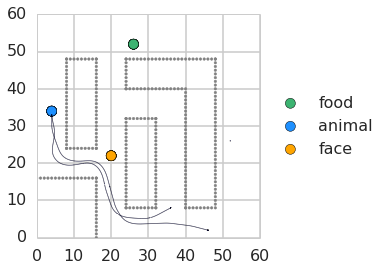

In [10]:
plot_paths(env='env1', subj='1', 
           dp=dp[dp.test_trial != 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x1264e4a90>,
 <matplotlib.axes.AxesSubplot at 0x12ac6dfd0>)

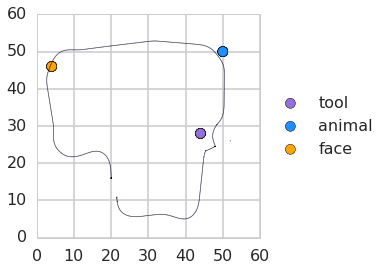

In [20]:
plot_paths(env='env3', subj='1', dp=dp, proj=proj)

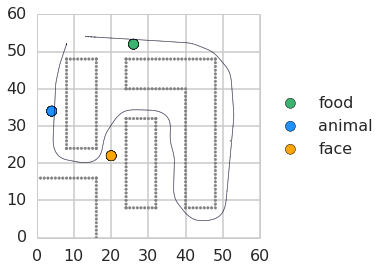

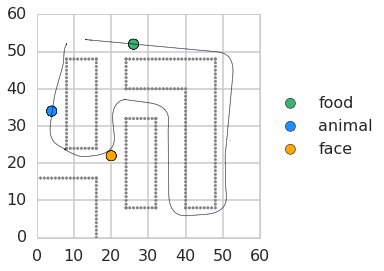

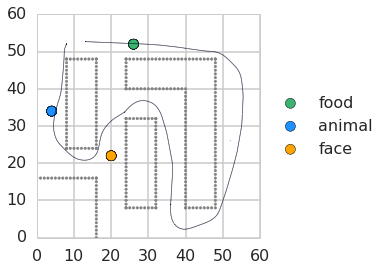

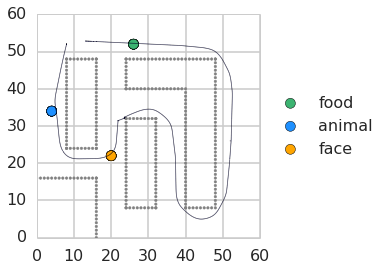

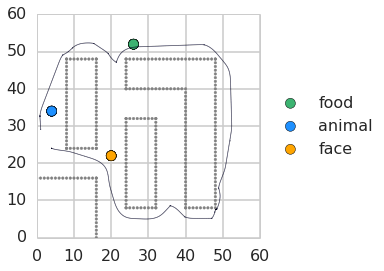

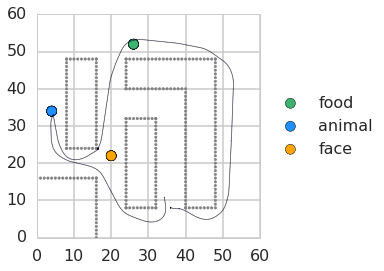

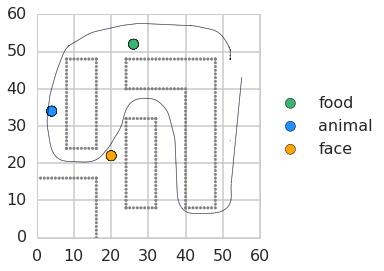

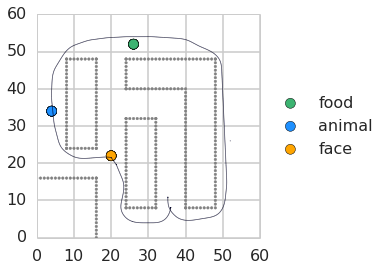

In [21]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env1', sub, dp, proj)

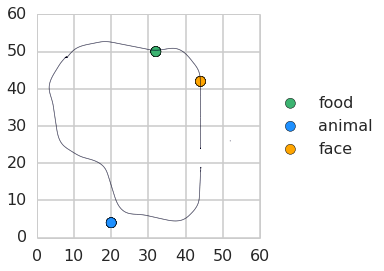

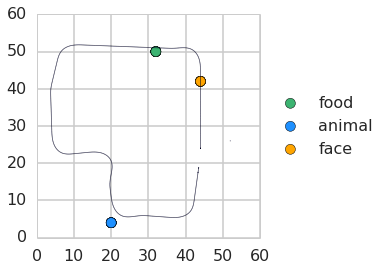

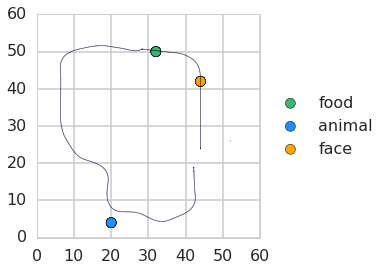

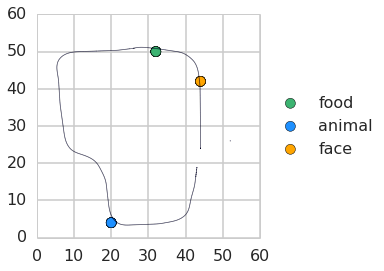

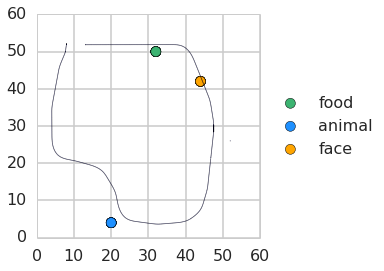

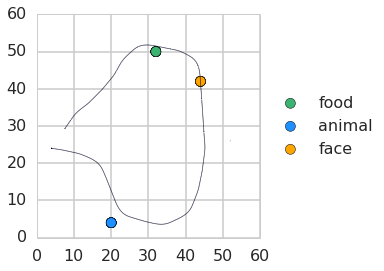

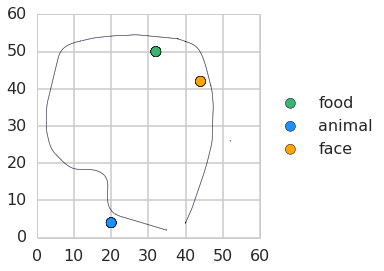

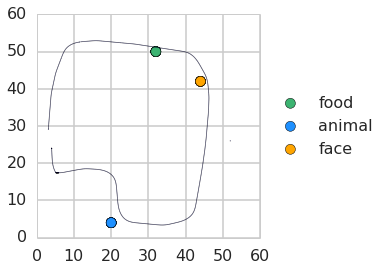

In [22]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env2', sub, dp, proj)

### Data for 1 subject, 1 environment

In [13]:
dsub = dp.query('env == "env1" & subid=="1" & c3=="PandaEPL_avatar"')
dsub.head()

,time,c3,subid,env,test_trial,x,y,z
5,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
13,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
15,6716,PandaEPL_avatar,1,env1,training,8,52,0.8
25,7086,PandaEPL_avatar,1,env1,training,8,52,0.8
27,7426,PandaEPL_avatar,1,env1,training,8,52,0.8


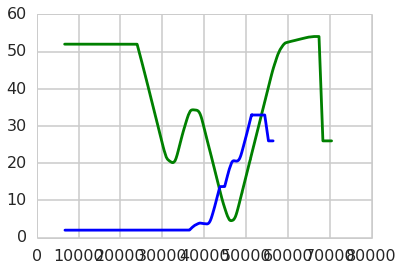

In [14]:
plt.plot(dsub[dsub.test_trial == 'training'].time, 
         dsub[dsub.test_trial == 'training'].y, 'green',
         dsub[dsub.test_trial == 'test1'].time, 
         dsub[dsub.test_trial == 'test1'].y, 'blue')

In [15]:
dsub.time.max()

70436

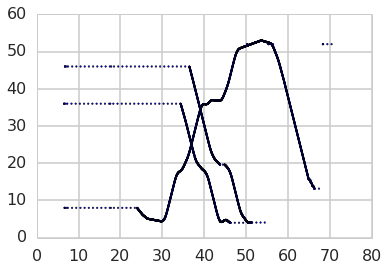

In [16]:
plt.scatter(dsub.time/1000, dsub.x.astype(float), 
            s=10, marker='.')

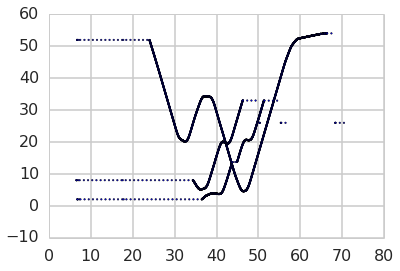

In [17]:
plt.scatter(dsub.time/1000, dsub.y.astype(float), 
            s=10, marker='.')

## Heading Direction

In [23]:
dh = df[(df.command == 'VROBJECT_HEADING') & (df.c3 == 'PandaEPL_avatar')].reset_index()
dh = dh.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dh.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,PandaEPL_avatar,90.0,1,env1,training
1,7986,21,PandaEPL_avatar,135.0,1,env1,training
2,9246,11,PandaEPL_avatar,180.0,1,env1,training
3,10506,11,PandaEPL_avatar,225.0,1,env1,training
4,11776,11,PandaEPL_avatar,270.0,1,env1,training


### Look at data just for 1 sub in 1 env

In [24]:
dsub = dh.query('env == "env3" & subid=="1"')
dsub.head()

,time,c2,c3,c4,subid,env,test_trial
3396,4173,1,PandaEPL_avatar,0.0,1,env3,training
3397,5503,21,PandaEPL_avatar,45.0,1,env3,training
3398,6753,21,PandaEPL_avatar,90.0,1,env3,training
3399,8003,21,PandaEPL_avatar,135.0,1,env3,training
3400,9273,11,PandaEPL_avatar,180.0,1,env3,training


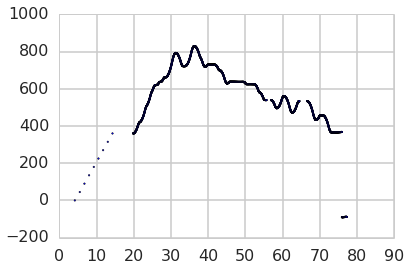

In [25]:
plt.scatter(dsub.time/1000, dsub.c4.astype(float), 
            s=10, marker='.')

## Text Events

In [26]:
dt = df[(df.command.isin(['ASSIGNED'])) 
        | df.command.isin(['ARRIVED'])].reset_index()
dt.ix[dt.command == 'ARRIVED', 'c3'] = 'between_trials'
dt = dt.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dt = dt.rename(columns={'c3': 'instructions'})
dt.head()

,time,instructions,subid,env,test_trial
0,17696,zzz,1,env1,training
1,66346,between_trials,1,env1,training
2,16591,zzz,1,env2,training
3,54331,between_trials,1,env2,training
4,15213,zzz,1,env3,training


In [27]:
dt['total_time'] = (dt.time - dt.time.shift(1)).shift(-1)
dt.head()

,time,instructions,subid,env,test_trial,total_time
0,17696,zzz,1,env1,training,48650
1,66346,between_trials,1,env1,training,-49755
2,16591,zzz,1,env2,training,37740
3,54331,between_trials,1,env2,training,-39118
4,15213,zzz,1,env3,training,58741


### Average time to navigate to goal

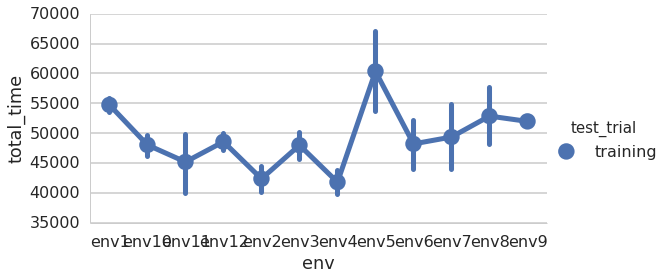

In [28]:
means = dt[dt.instructions != 'between_trials'].merge(subj_info).groupby(['subid', 'test_trial', 'env']).mean().reset_index()
sns.factorplot(x='env', y='total_time', aspect=2, hue='test_trial',
               units='subid', ci=68, dodge=.1,
               data=means)

## Input Events

In [29]:
di = df[(df.command == 'INPUT_EVENT')].reset_index()
di = di.drop(['c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
di = di.query('(c3 != "dismiss") & (c3 != "exit")')
di.head()

,time,c2,c3,subid,env,test_trial
0,22156,0,turnLeft,1,env1,training
1,22166,0,turnLeft,1,env1,training
2,22186,0,turnLeft,1,env1,training
3,22206,0,turnLeft,1,env1,training
4,22216,0,turnLeft,1,env1,training


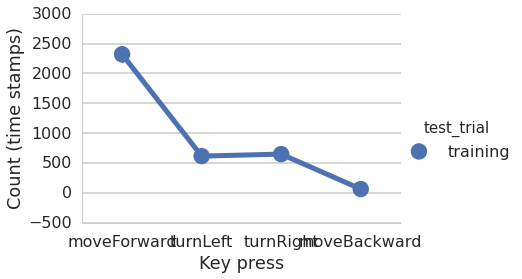

In [30]:
counts = di.merge(subj_info).groupby(['subid', 'test_trial', 'env', 'c3']).count().reset_index()

sns.factorplot(x='c3', y='time', aspect=1.5, hue='test_trial',
               units='subid', ci=68, data=counts)
plt.ylabel('Count (time stamps)')
plt.xlabel('Key press')

## Merge dataframes

In [33]:
dpt = dp.merge(dt, on=['subid', 'env', 'test_trial', 'time'], how='left')
dpt.ix[0,'instructions'] = 'intro'
dpt = dpt.fillna(method='ffill')
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [34]:
dpt.query('env == "env1" & c3 == "lettuce"')

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
31596,6906,lettuce,2,env1,training,26,52,0.5,between_trials,-51150
62187,6863,lettuce,3,env1,training,26,52,0.5,between_trials,-54491
90966,6971,lettuce,4,env1,training,26,52,0.5,between_trials,-43596
121741,6742,lettuce,5,env1,training,26,52,0.5,between_trials,-48726
152245,6648,lettuce,6,env1,training,26,52,0.5,between_trials,-50148
185937,6678,lettuce,7,env1,training,26,52,0.5,between_trials,-47962
209396,6854,lettuce,8,env1,training,26,52,0.5,between_trials,-53648


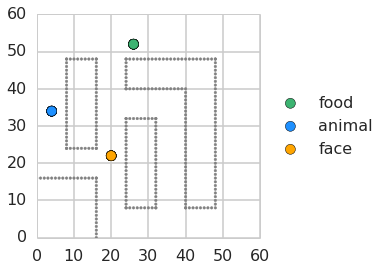

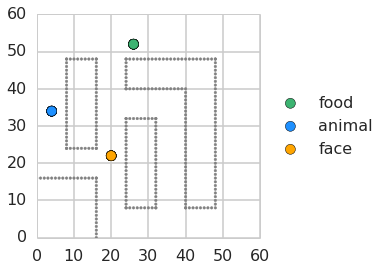

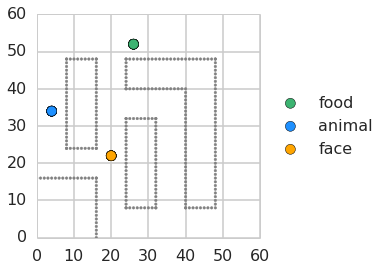

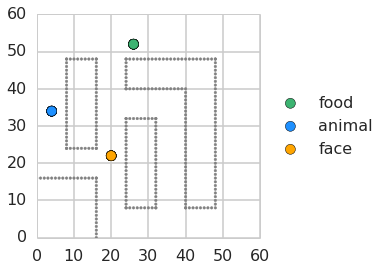

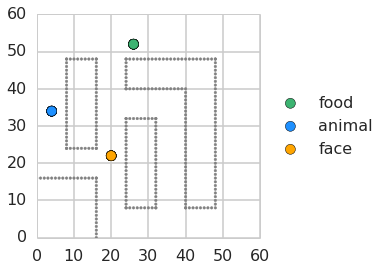

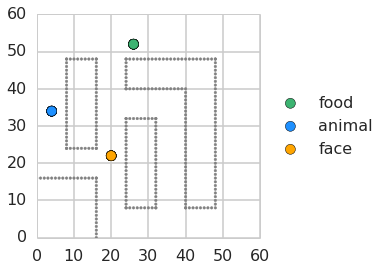

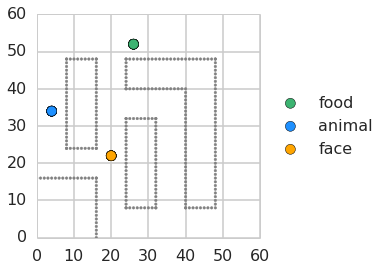

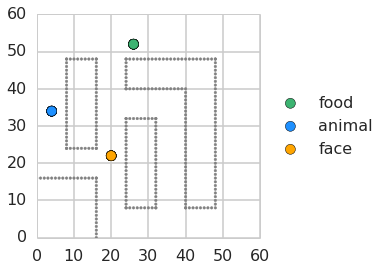

In [35]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_path('env1', sub, 'zebra', dpt, proj, dp)

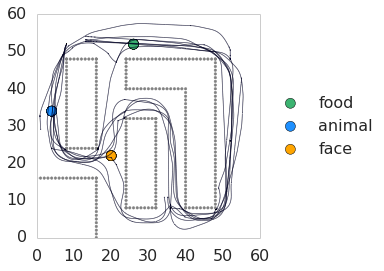

In [36]:
plot_paths_group('env1', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

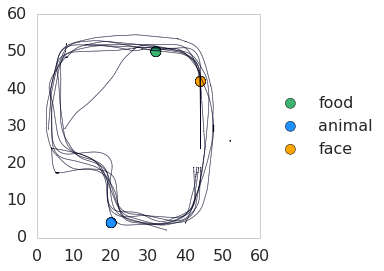

In [49]:
plot_paths_group('env2', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

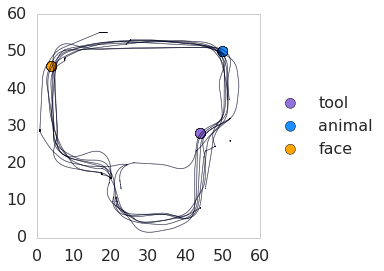

In [50]:
plot_paths_group('env3', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

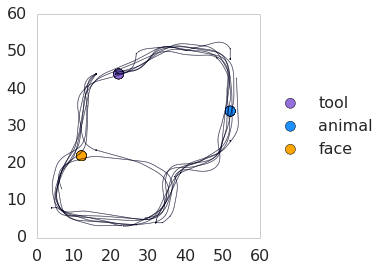

In [51]:
plot_paths_group('env4', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

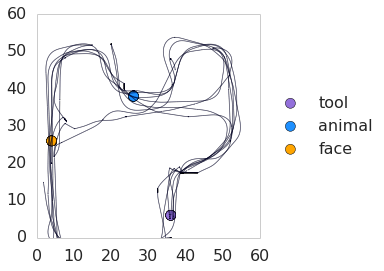

In [52]:
plot_paths_group('env5', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

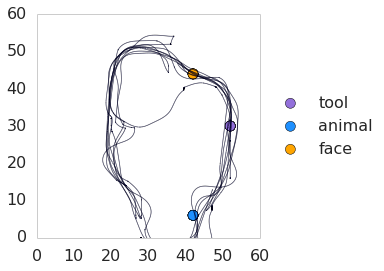

In [53]:
plot_paths_group('env6', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

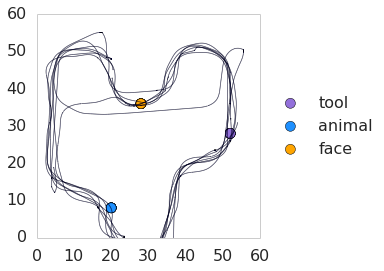

In [54]:
plot_paths_group('env7', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

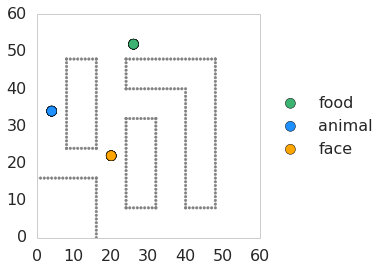

In [37]:
plot_paths_group('env1', subj_info.subid, 
                 dpt.query('test_trial != "training"'), proj, dp)
plt.grid(0)

(<matplotlib.figure.Figure at 0x121d85a90>,
 <matplotlib.axes.AxesSubplot at 0x129926ad0>)

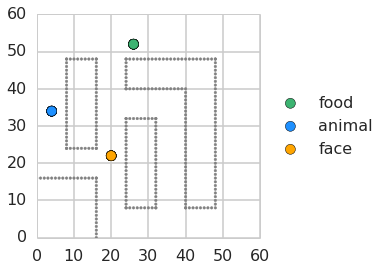

In [38]:
plot_path_group('env1', subj_info.subid, 'zebra', dpt, proj, dp)

(<matplotlib.figure.Figure at 0x1250a1050>,
 <matplotlib.axes.AxesSubplot at 0x1294bb050>)

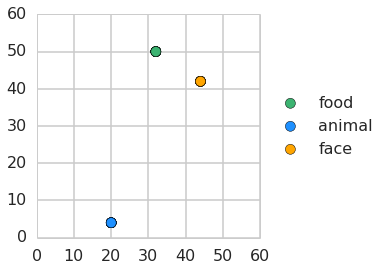

In [39]:
plot_path_group('env2', subj_info.subid, 'Mark_Zuckerberg', dpt, proj, dp)

In [40]:
dpt.query('env == "env3"').instructions.unique()

array(['between_trials', 'zzz'], dtype=object)

(<matplotlib.figure.Figure at 0x12a28bd10>,
 <matplotlib.axes.AxesSubplot at 0x12a29f1d0>)

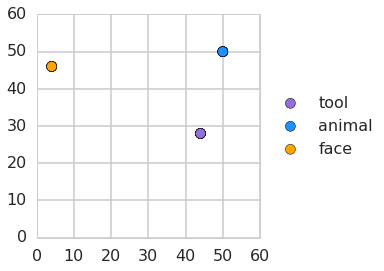

In [41]:
plot_path_group('env3', subj_info.subid, 'brown_bear', dpt, proj, dp)

In [42]:
dpt.query('env == "env4"').instructions.unique()

array(['between_trials', 'zzz'], dtype=object)

(<matplotlib.figure.Figure at 0x125108650>,
 <matplotlib.axes.AxesSubplot at 0x12a3da690>)

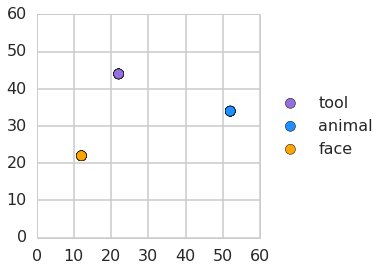

In [43]:
plot_path_group('env4', subj_info.subid, 'saw', dpt, proj, dp)

## Calculate Path Lengths

In [44]:
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [45]:
dplen = pd.DataFrame(columns=['subid', 'env', 'goal_type', 'path_len'])

for env in proj['envs']:
    goals = set(dpt[dpt.env == env].instructions)
    goals.discard('between_trials')
    goals.discard('intro')

    for subid in subj_info.subid:
#         print subid
        
        for goal in goals:
#             print goal

            goal_type = dict((v,k) for k,v in proj['goals'][env].items()).get(goal)
#             print goal_type
            data_sub = dpt[(dpt.subid == subid) & (dpt.env == env) & 
                           (dpt.instructions == goal) & 
                           (dpt.c3 == 'PandaEPL_avatar')]
            distance = sp.spatial.distance.euclidean(data_sub.x, data_sub.y)
            
            row = pd.Series({'subid': subid,
                             'env': env,
                             'goal_type': goal_type,
                             'path_len': distance})
            dplen = dplen.append(row, ignore_index=True)

In [46]:
dplen.head()

,subid,env,goal_type,path_len
0,1,env1,None,1259.605132
1,2,env1,None,1231.693554
2,3,env1,None,1279.596593
3,4,env1,None,1226.222300
4,5,env1,None,1334.310211


In [47]:
means = dplen.merge(subj_info).groupby(['subid', 'goal_type']).mean().reset_index()

sns.factorplot(x='goal_type', y='path_len', 
               units='subid', ci=68, dodge=.1,
               data=means)

ValueError: min() arg is an empty sequence

In [ ]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               col='subid', col_wrap=2,
               dodge=.1,
               data=means)

In [ ]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means, )